In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

In [2]:
lines = []
with open('data/lines.txt', 'r') as file:
    for line in file.readlines():
        if not line.strip() or line.startswith('#'):
            continue
        if line.split()[1] == 'err':
            continue
        lines.append(line[:-1])

In [3]:
lines[:10]

['a01-000u-00 ok 154 19 408 746 1661 89 A|MOVE|to|stop|Mr.|Gaitskell|from',
 'a01-000u-01 ok 156 19 395 932 1850 105 nominating|any|more|Labour|life|Peers',
 'a01-000u-02 ok 157 16 408 1106 1986 105 is|to|be|made|at|a|meeting|of|Labour',
 'a01-000u-04 ok 157 20 395 1474 1830 94 put|down|a|resolution|on|the|subject',
 'a01-000u-06 ok 159 20 363 1825 2051 87 Griffiths|,|M P|for|Manchester|Exchange|.',
 'a01-000x-00 ok 182 30 375 748 1561 148 A|MOVE|to|stop|Mr.|Gaitskell|from|nominating',
 'a01-000x-01 ok 181 23 382 924 1595 148 any|more|Labour|life|Peers|is|to|be|made|at|a',
 'a01-000x-02 ok 181 30 386 1110 1637 140 meeting|of|Labour|0M Ps|tomorrow|.|Mr.|Michael',
 'a01-000x-03 ok 179 22 375 1276 1584 154 Foot|has|put|down|a|resolution|on|the|subject',
 'a01-000x-04 ok 173 25 397 1458 1647 148 and|he|is|to|be|backed|by|Mr.|Will|Griffiths|,']

In [4]:
p = Path('data/lines')
prepared_lines = []
for i in range(len(lines)):
    line = lines[i]
    info = line.split()[0].split('-')
    prepared_lines.append((p / info[0] / f"{info[0]}-{info[1]}" / f"{'-'.join(info)}.png" , line.count('|') + 1))

In [5]:
prepared_lines[0]

(WindowsPath('data/lines/a01/a01-000u/a01-000u-00.png'), 7)

In [6]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = ImageOps.grayscale(image)
    image = np.asarray(image)
    return image

In [877]:
i = 345
images = []
for path, k in prepared_lines[i:i+1]:
    images.append((preprocess_image(path), k))

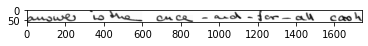

In [878]:
plt.imshow(images[0][0], cmap='gray')

In [879]:
from sklearn.cluster import DBSCAN

In [880]:
image = images[0][0]
image.shape

(60, 1742)

In [881]:
img = np.where(image < 160)

In [882]:
condition = np.sum(image < 160, axis=0) == 0
ref_counter: np.array = np.diff(np.where(np.concatenate(([condition[0]],
                                     condition[:-1] != condition[1:],
                                     [True])))[0])[::2]
ref_counter.sort()
ref_counter = ref_counter[::-1]
ref_counter = ref_counter[ref_counter > 5]
m = np.min(ref_counter)
print(ref_counter)
ref_counter = ref_counter[ref_counter > m + 10]
k = ref_counter[-1]
k, ref_counter

[83 74 73 45 34 32 27 24 23 17 15 15 13  8  7]


(23, array([83, 74, 73, 45, 34, 32, 27, 24, 23], dtype=int64))

In [883]:
idx = np.column_stack((img[0], img[1]))

In [884]:
def metric(x, y):
    return abs(x[1] - y[1])

In [885]:
db = DBSCAN(eps=k, min_samples=1, metric=metric).fit(idx)

In [886]:
set(db.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

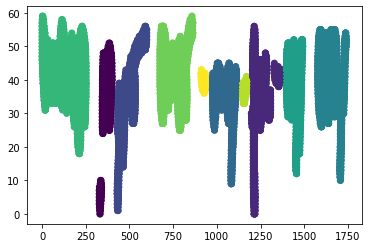

In [887]:
plt.scatter(idx[:,1], idx[:,0], c=db.labels_)

In [888]:
from dataclasses import dataclass

@dataclass
class Point:
    x: int
    y: int

@dataclass
class Clip:
    top: Point
    left: Point
    bottom: Point
    right: Point

c = [Clip(Point(0,0), Point(image.shape[0], image.shape[1]), Point(image.shape[0], image.shape[1]), Point(0, 0)) for _ in range(max(set(db.labels_)) + 1)]
c

[Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bottom=Point(x=60, y=1742), right=Point(x=0, y=0)),
 Clip(top=Point(x=0, y=0), left=Point(x=60, y=1742), bo

In [889]:
for i, point in enumerate(idx):
    label = db.labels_[i]
    if label == -1:
        continue
    if label == 1:
        print(point[0], point[1])
    if label == 1:
        print(c[label].left)

    if c[label].top.x < point[0]:
        c[label].top = Point(*point)
    if c[label].bottom.x > point[0]:
        c[label].bottom = Point(*point)
    if c[label].right.y < point[1]:
        c[label].right = Point(*point)
    if c[label].left.y > point[1]:
        c[label].left = Point(*point)
    if label == 1:
        print(c[label].left)

0 1212
Point(x=60, y=1742)
Point(x=0, y=1212)
0 1213
Point(x=0, y=1212)
Point(x=0, y=1212)
0 1214
Point(x=0, y=1212)
Point(x=0, y=1212)
0 1215
Point(x=0, y=1212)
Point(x=0, y=1212)
0 1216
Point(x=0, y=1212)
Point(x=0, y=1212)
0 1217
Point(x=0, y=1212)
Point(x=0, y=1212)
0 1218
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1212
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1213
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1214
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1215
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1216
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1217
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1218
Point(x=0, y=1212)
Point(x=0, y=1212)
1 1219
Point(x=0, y=1212)
Point(x=0, y=1212)
2 1211
Point(x=0, y=1212)
Point(x=2, y=1211)
2 1212
Point(x=2, y=1211)
Point(x=2, y=1211)
2 1213
Point(x=2, y=1211)
Point(x=2, y=1211)
2 1214
Point(x=2, y=1211)
Point(x=2, y=1211)
2 1215
Point(x=2, y=1211)
Point(x=2, y=1211)
2 1216
Point(x=2, y=1211)
Point(x=2, y=1211)
2 1217
Point(x=2, y=1211)
Point(x=2, y=1211)
2 1218
Po

In [890]:
c.sort(key=lambda x: x.left.y)
c

[Clip(top=Point(x=59, y=2), left=Point(x=46, y=0), bottom=Point(x=18, y=211), right=Point(x=39, y=253)),
 Clip(top=Point(x=51, y=383), left=Point(x=3, y=327), bottom=Point(x=0, y=331), right=Point(x=40, y=401)),
 Clip(top=Point(x=56, y=588), left=Point(x=6, y=429), bottom=Point(x=1, y=432), right=Point(x=52, y=599)),
 Clip(top=Point(x=59, y=857), left=Point(x=38, y=674), bottom=Point(x=25, y=785), right=Point(x=54, y=863)),
 Clip(top=Point(x=43, y=911), left=Point(x=41, y=909), bottom=Point(x=36, y=927), right=Point(x=39, y=939)),
 Clip(top=Point(x=45, y=1002), left=Point(x=36, y=974), bottom=Point(x=9, y=1081), right=Point(x=39, y=1114)),
 Clip(top=Point(x=41, y=1169), left=Point(x=36, y=1147), bottom=Point(x=33, y=1151), right=Point(x=38, y=1173)),
 Clip(top=Point(x=56, y=1213), left=Point(x=30, y=1197), bottom=Point(x=0, y=1212), right=Point(x=42, y=1372)),
 Clip(top=Point(x=52, y=1440), left=Point(x=38, y=1397), bottom=Point(x=12, y=1455), right=Point(x=50, y=1492)),
 Clip(top=Poin

In [891]:
img_clips = []
for i, clip in enumerate(c):
    if img_clips:
        last = img_clips[-1]
        if last.right.y > clip.right.y:
            if last.top.x < clip.top.x:
                last.top = clip.top
            if last.bottom.y > clip.bottom.y:
                last.bottom = clip.bottom
            continue
        print(metric((last.right.x, last.right.y), (clip.left.x, clip.left.y)))
        if metric((last.right.x, last.right.y), (clip.left.x, clip.left.y)) < k:
            last.right = clip.right
            if last.top.x < clip.top.x:
                last.top = clip.top
            if last.bottom.x > clip.bottom.x:
                last.bottom = clip.bottom
            continue
    img_clips.append(clip)

img_clips = [image[clip.bottom.x:clip.top.x, clip.left.y:clip.right.y] for clip in img_clips]

74
28
75
46
35
33
24
25
84


In [892]:
img_clips[0]

array([[255, 255, 255, ..., 251, 251, 251],
       [255, 255, 255, ..., 250, 251, 251],
       [255, 255, 255, ..., 251, 251, 251],
       ...,
       [ 75,  76,  78, ..., 251, 251, 251],
       [ 88,  80,  86, ..., 255, 255, 255],
       [160,  97,  81, ..., 255, 255, 255]], dtype=uint8)

10


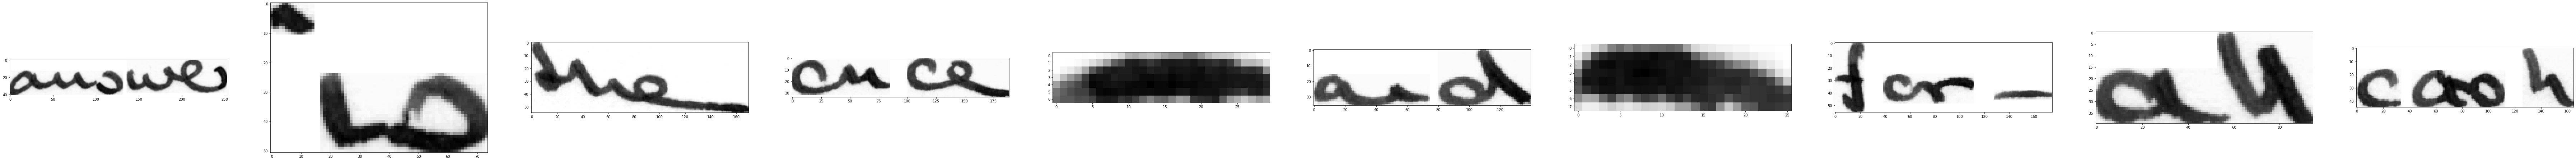

In [893]:
n = len(img_clips)
print(n)
f, axarr = plt.subplots(1, n, figsize=(128,32))
for i, img_clip in enumerate(img_clips):
    axarr[i].imshow(img_clip, cmap='gray')

In [894]:
images[0][1]

5

In [895]:
from keras_words import process_grayscale_images, WordsModel, decode_batch_predictions
import tensorflow as tf

(41, 253, 1)
1/1 [==============================] - 0s 31ms/step
(51, 74, 1)
1/1 [==============================] - 0s 31ms/step
(55, 170, 1)
1/1 [==============================] - 0s 16ms/step
(34, 189, 1)
1/1 [==============================] - 0s 31ms/step
(7, 30, 1)
1/1 [==============================] - 0s 16ms/step
(36, 140, 1)
1/1 [==============================] - 0s 16ms/step
(8, 26, 1)
1/1 [==============================] - 0s 16ms/step
(56, 175, 1)
1/1 [==============================] - 0s 31ms/step
(40, 95, 1)
1/1 [==============================] - 0s 16ms/step
(45, 165, 1)
1/1 [==============================] - 0s 16ms/step


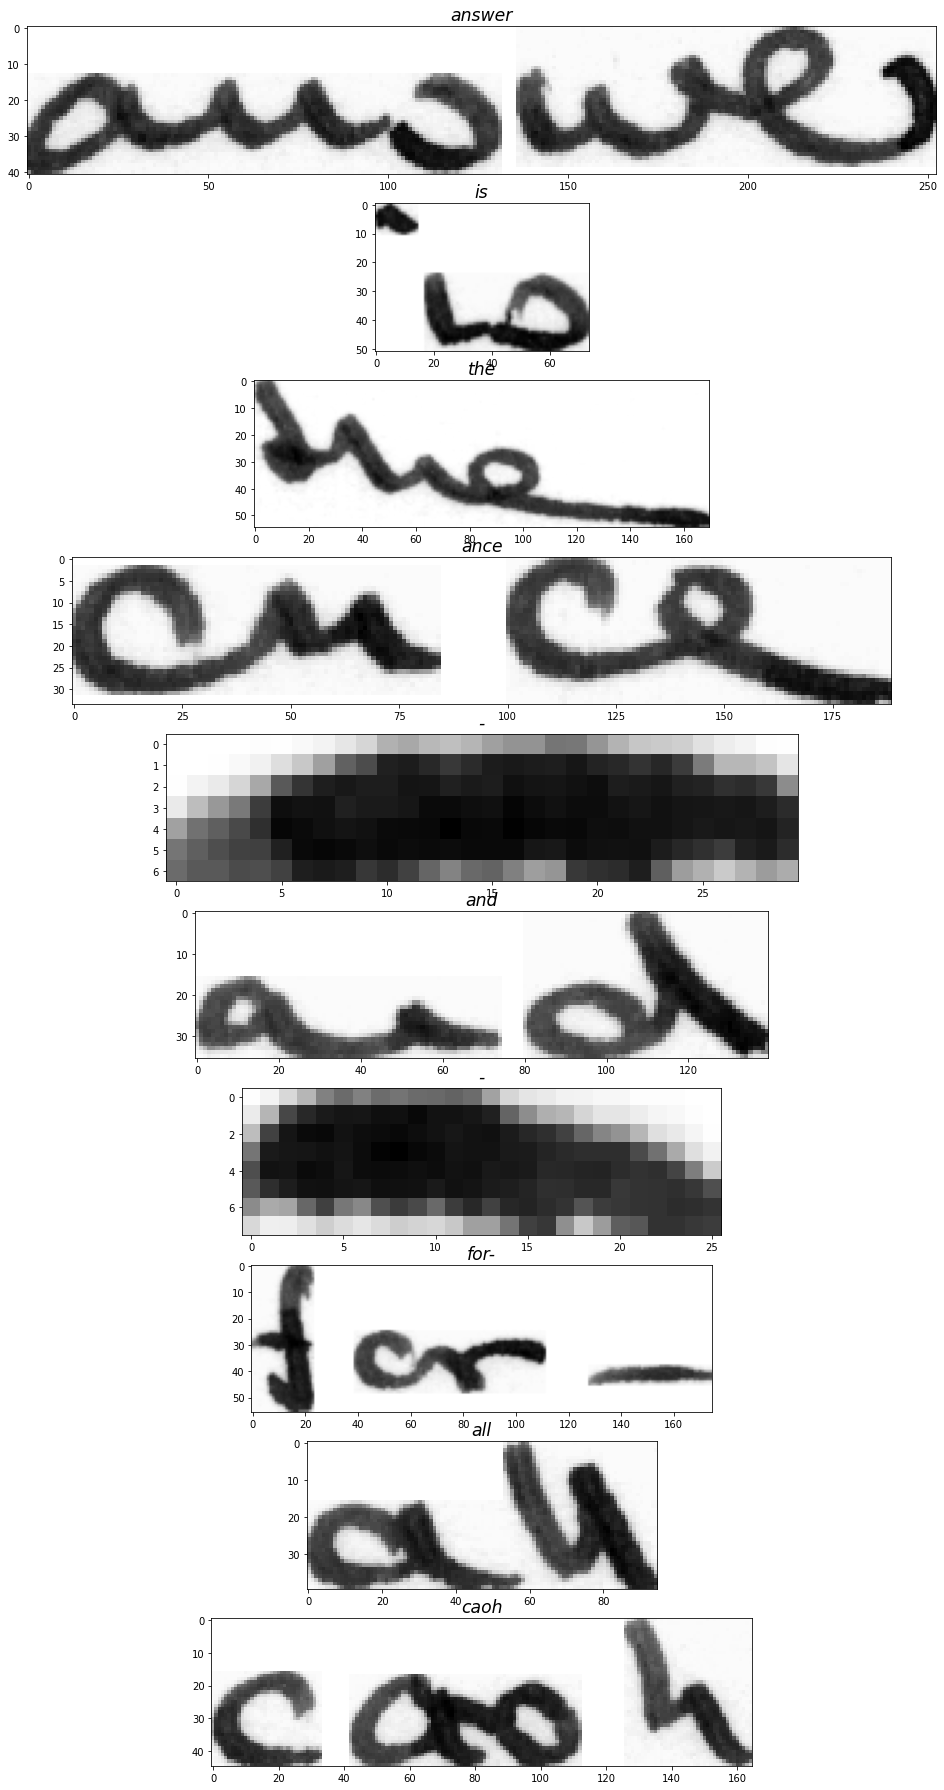

In [896]:
n = len(img_clips)
f, axarr = plt.subplots(n, 1, figsize=(128,32))
line = []
for i, img_clip in enumerate(img_clips):
    temp = img_clip[..., tf.newaxis]
    processed_image = process_grayscale_images([temp])
    pred = WordsModel.predict(processed_image)
    label = decode_batch_predictions(pred)
    line.append(label[0])
    ax = axarr[i]
    ax.imshow(img_clip, cmap='gray')
    ax.set_title(label[0], fontstyle='italic', fontsize='xx-large')

In [897]:
' '.join(line)

'answer is the ance - and - for- all caoh'